# Breast Cancer Campaign
Predict if a breast cancer diagnosis is Malign or Benign based on the measurements from the breast exam

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import time

from correlation_feature_selection import get_relevant_non_redundant_features, sort_feature_by_relevance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE


%matplotlib inline

In [2]:
df = pd.read_csv('breast_cancer_data.csv')
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [3]:
display(df.info())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

None

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

# Drop the last column because it only has missing values

In [4]:
df.drop(columns=['Unnamed: 32'], inplace=True)

# Create a Series containig the target

In [5]:
target_df = df.iloc[:,0].copy()
target_df[:]=0
target_df[df.diagnosis=="M"]=1

# Create a dataframe with only the feature values

In [6]:
features_df = df.iloc[:,2:]
feat_names = features_df.columns

# Plot all features correlation matrix and their relevance with respect to the target

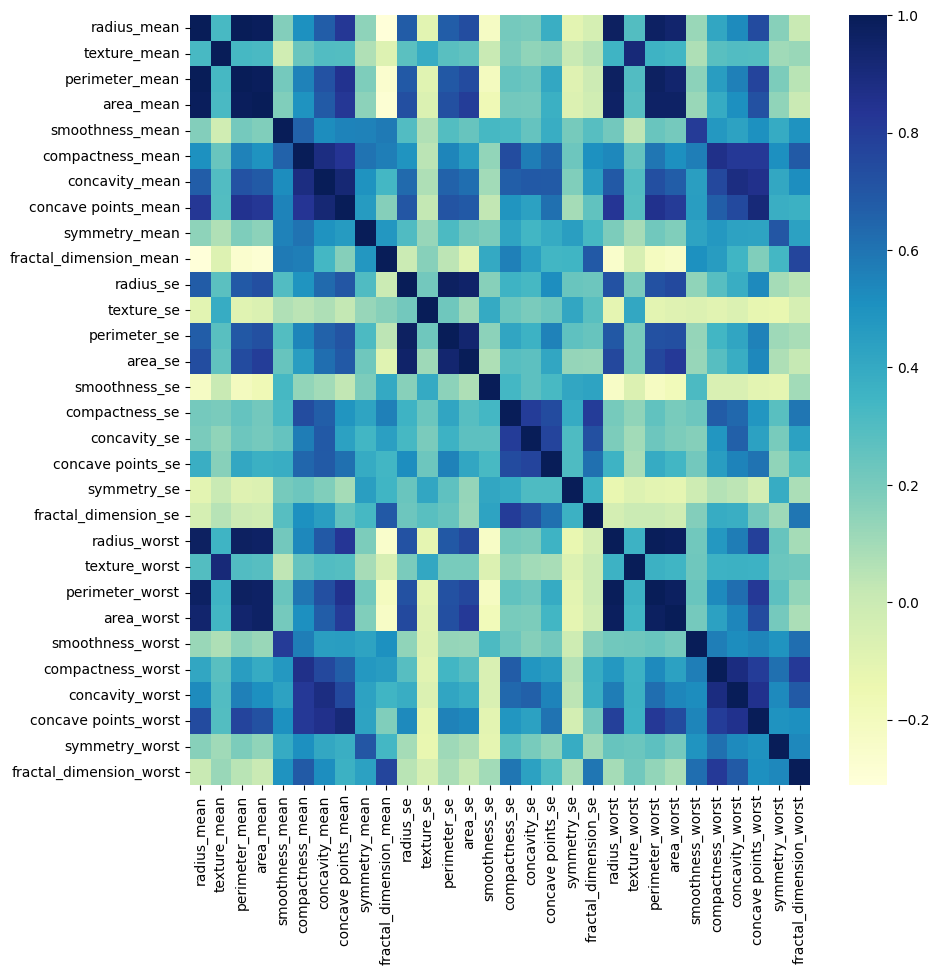

In [7]:
# plotting correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(features_df.corr(), cmap="YlGnBu", annot=False)
plt.show() 

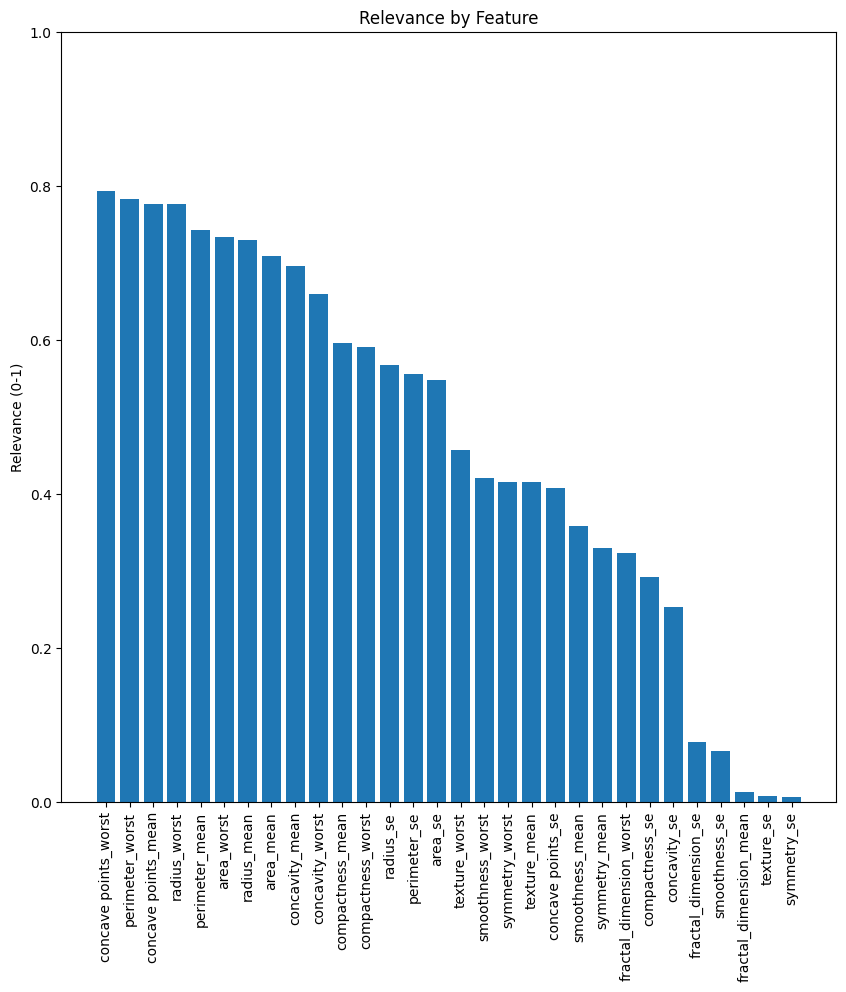

In [8]:
sort_idxs, all_features_relevance = sort_feature_by_relevance(features_df.values, target_df.values, th=0)
features_names_by_relevance = feat_names[sort_idxs]
plt.figure(figsize=(10,10))
g = plt.bar(x=features_names_by_relevance, height=all_features_relevance, label=features_names_by_relevance)

plt.ylabel('Relevance (0-1)')
plt.title('Relevance by Feature')
plt.xticks(rotation = 90)
plt.ylim(0, 1)

plt.show() 

# Feature Selection

In [9]:
display(np.shape(features_df.values))
display(features_df.columns)

(569, 30)

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [10]:
X, sel_feat_names, sel_feature_relevance = get_relevant_non_redundant_features(features_df.values, target_df.values, feat_names, relevance_th=0.2, redundancy_th=0.5, plot=False)

In [11]:
sel_feat_names

Index(['concave points_worst', 'texture_worst', 'symmetry_mean',
       'compactness_se'],
      dtype='object')

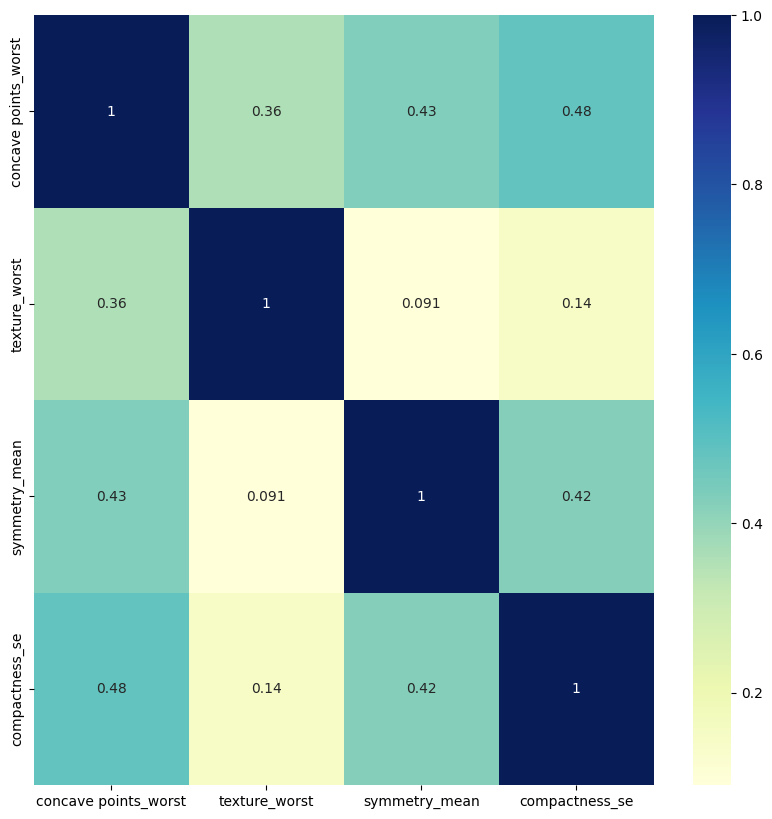

In [12]:
# plotting correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(features_df[sel_feat_names].corr(), cmap="YlGnBu", annot=True)
plt.show() 

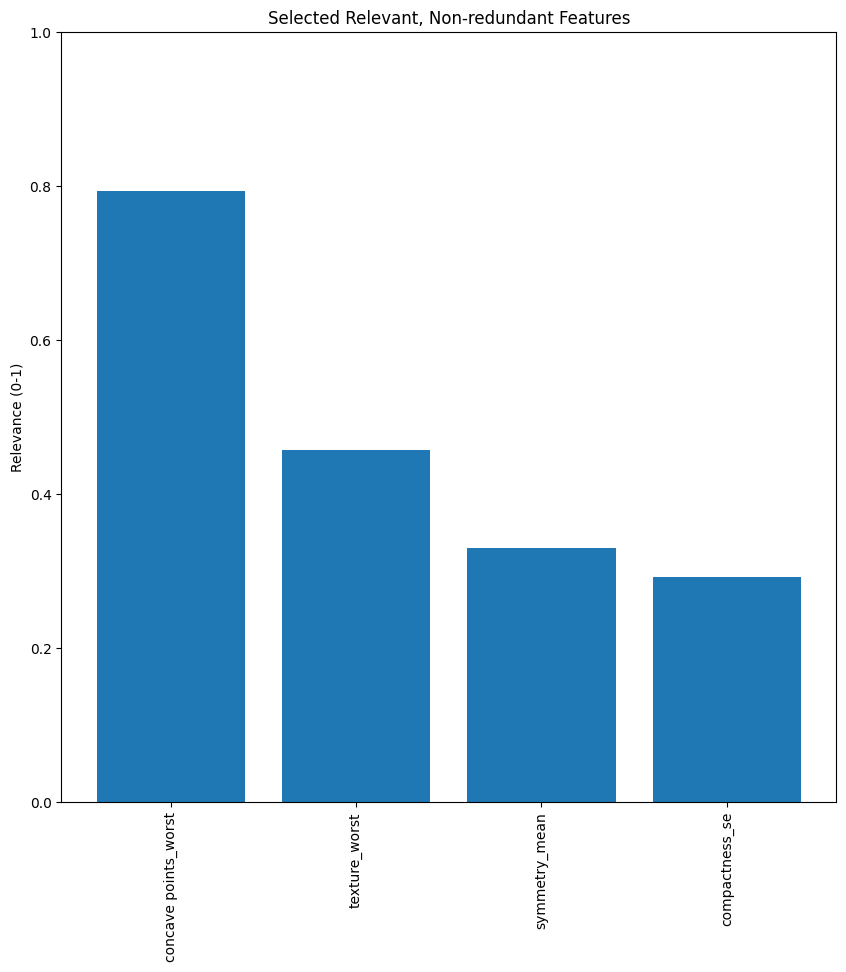

In [13]:
plt.figure(figsize=(10,10))
g = plt.bar(x=sel_feat_names, height=sel_feature_relevance, label=sel_feat_names)

plt.ylabel('Relevance (0-1)')
plt.title('Selected Relevant, Non-redundant Features')
plt.xticks(rotation = 90)
plt.ylim(0, 1)

plt.show() 

# Create a dataframe with the selected feature set, normalize the features and add the target to the dataframe

In [14]:
sel_feats_df = features_df[sel_feat_names].copy()
for feat_name in sel_feats_df.columns:
    sel_feats_df[feat_name] = (sel_feats_df[feat_name]-sel_feats_df[feat_name].mean())/sel_feats_df[feat_name].std()

sel_feats_df['diagnosis'] = target_df.values
sel_feats_df

,concave points_worst,texture_worst,symmetry_mean,compactness_se,diagnosis
0,2.294058,-1.358098,2.215566,1.315704,1
1,1.086129,-0.368879,0.001391,-0.692317,1
2,1.953282,-0.023953,0.938859,0.814257,1
3,2.173873,0.133866,2.864862,2.741868,1
4,0.728618,-1.465481,-0.009552,-0.048477,1
...,...,...,...,...,...
564,1.627719,0.117596,-0.312314,0.191637,1
565,0.733182,2.045599,-0.217473,-0.069697,1
566,0.413705,1.373645,-0.808406,0.660696,1
567,2.287972,2.235958,2.135315,2.015943,1


# Create the pair plot for the selected features

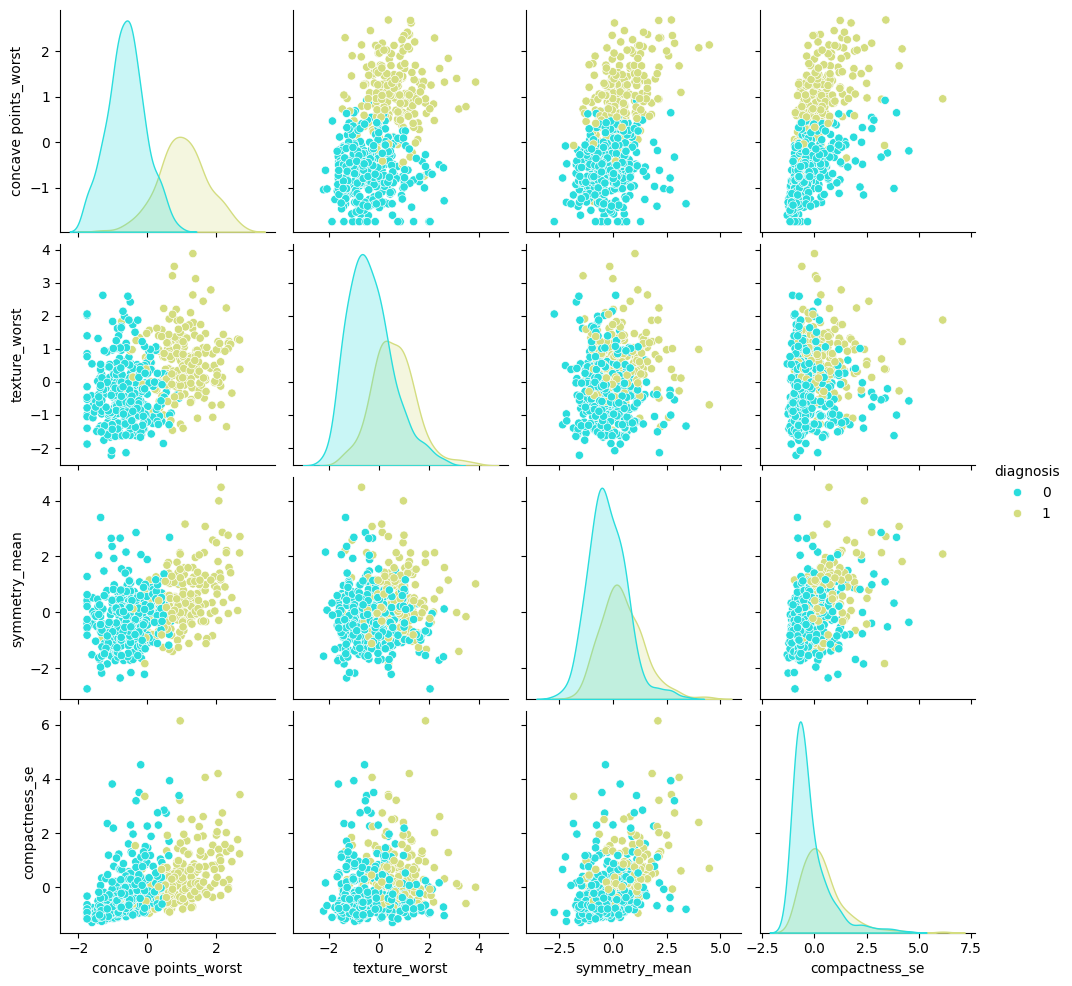

In [15]:
g = sns.pairplot(sel_feats_df,hue="diagnosis",palette="rainbow")
#plt.savefig("Selected_Features_PairPlot.png")

# Generate Violin plots for the selected features
The violin plots compare the classes malignant and benign, they do this by showing not only the values from each feature bu also an estimate of the shape of their distribution


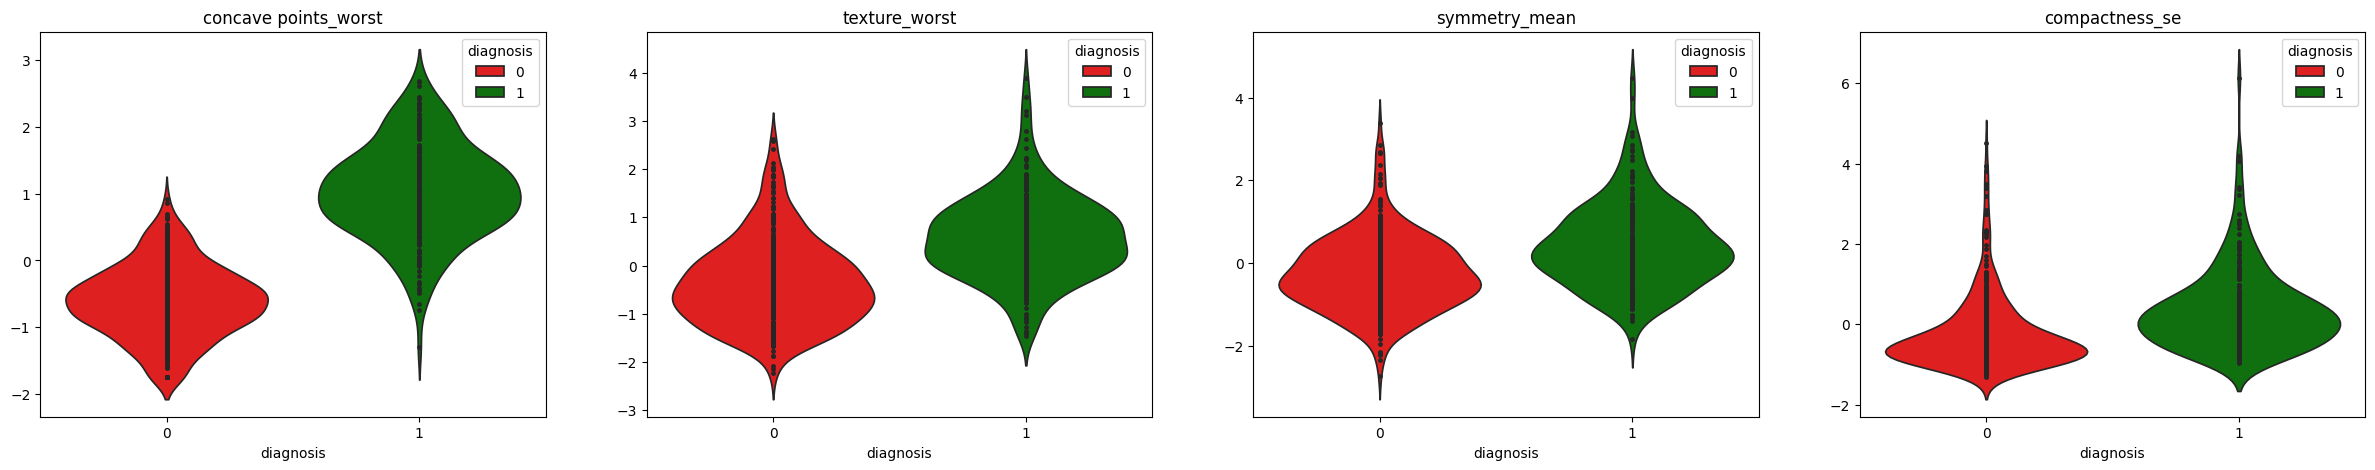

In [16]:
f, axes = plt.subplots(1, len(sel_feats_df.columns)-1, figsize=(30, 5))
for idx, feature_name in enumerate(sel_feats_df.columns):
    if feature_name!="diagnosis":
        g = sns.violinplot(data=sel_feats_df, x="diagnosis", y=feature_name, inner="points", hue="diagnosis", palette=['r','g'],ax=axes[idx])
        g.set(ylabel=None, title= feature_name);

#plt.savefig("Selected_Features_ViolinPlot.png")

In [17]:
number_positives_perc = sum(sel_feats_df["diagnosis"]) / len(sel_feats_df)
number_positives_perc

0.37258347978910367

# Generate training, validation and testing data

In [18]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(sel_feats_df.iloc[:,:-1].values, sel_feats_df.iloc[:,-1].values, test_size=0.1, random_state=0)
display(np.shape(X_train_valid))
display(np.shape(X_test))
display(np.shape(y_train_valid))
display(np.shape(y_test))

(512, 4)

(57, 4)

(512,)

(57,)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)
display(np.shape(X_train_valid))
display(np.shape(X_test))
display(np.shape(y_train_valid))
display(np.shape(y_test))

(512, 4)

(57, 4)

(512,)

(57,)

In [20]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_valid, y_valid = sm.fit_resample(X_valid, y_valid)
display(np.shape(X_train_valid))
display(np.shape(X_test))
display(np.shape(y_train_valid))
display(np.shape(y_test))

(512, 4)

(57, 4)

(512,)

(57,)

# Train the model on the training set and adjust K on the validation set

In [21]:
def objective(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    "random_state": trial.suggest_categorical("random_state", [42]),
    }
    
    model = RandomForestClassifier(**params).fit(X_train, y_train)

    y_predicted = model.predict(X_valid)
    (tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted).ravel()
    f1_val = (2*tp)/(2*tp+fp+fn)
    
    return f1_val


In [22]:
start_time = time.time()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "maximize")
func = lambda trial: objective(trial, X_train, X_valid, y_train, y_valid)

# Start optimizing with 100 trials
study.optimize(func, n_trials = 100)

total_time = time.time()-start_time
print(f"total_time={total_time}")
print(study.best_params)
print(study.best_value)

total_time=63.601829051971436
{'n_estimators': 10, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'random_state': 42}
0.9618320610687023


In [23]:
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {best_trial.number}")
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

  Value: 0.9618320610687023
Number of finished trials:  100
Best trial: 8
  Params: 
    n_estimators: 10
    max_depth: 6
    min_samples_split: 4
    min_samples_leaf: 1
    criterion: gini
    random_state: 42


# Train model with optimized hyperparameters and run on test set 

In [24]:
X_train_valid = np.concatenate((X_train, X_valid))
y_train_valid = np.concatenate((y_train, y_valid))

model = RandomForestClassifier(**best_trial.params).fit(X_train_valid, y_train_valid)

y_predicted = model.predict(X_test)

(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted).ravel()
precision_val = float(tp)/float(tp+fp)
recall_val = float(tp)/float(tp+fn)
specificity_val = float(tn)/float(tn+fp)
accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
f1_val = (2*tp)/(2*tp+fp+fn)
mcc_val = float((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


print("\n")
print("Test set precision_val =", precision_val)
print("Test set recall_val =", recall_val)
print("Test set sspecificity =", specificity_val)
print("Test set mcc_val =", mcc_val)
print("Test set accuracy_val =", accuracy_val)
print("Test set f1_val =", f1_val)



Test set precision_val = 1.0
Test set recall_val = 0.8636363636363636
Test set sspecificity = 1.0
Test set mcc_val = 0.8918825850158447
Test set accuracy_val = 0.9473684210526315
Test set f1_val = 0.926829268292683
